# DCGAN

[notebook](https://github.com/nttuan8/GAN_Tutorial/blob/master/G2/DCGAN.ipynb)

In [1]:
!nvidia-smi

Mon May 29 16:08:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from tqdm import tqdm_notebook

from keras.models import Sequential,Model
from keras.layers import Input,ReLU,LeakyReLU,Dense,BatchNormalization
from keras.layers.core import Activation, Reshape, Flatten
from keras.layers.convolutional import Conv2D,Conv2DTranspose
from keras.datasets import cifar10
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, SGD

In [3]:
def build_generator(z_dim=128,n_filter=64):
    init = RandomNormal(stddev=0.02)
    
    G = Sequential()
    G.add(Dense(2*2*n_filter*8, input_shape=(z_dim,), use_bias=True, kernel_initializer=init))
    
    # 2*2*512
    G.add(Reshape((2,2,n_filter*8)))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 4*4*256
    G.add(Conv2DTranspose(n_filter*4,kernel_size=(5,5),strides=2,padding='same',use_bias=True,kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 8*8*128
    G.add(Conv2DTranspose(n_filter*2,kernel_size=(5,5),strides=2,padding='same',use_bias=True,kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 16*16*128
    G.add(Conv2DTranspose(n_filter,kernel_size=(5,5),strides=2,padding='same',use_bias=True,kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 32*23*3
    G.add(Conv2DTranspose(3,kernel_size=(5,5),strides=2,padding='same',use_bias=True,kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(Activation('tanh'))
    
    print('Build Generator')
    print(G.summary())
    
    return G

In [4]:
# Test generator
generator = build_generator(z_dim=128,n_filter=64)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Build Generator
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              264192    
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 4, 

In [5]:
def build_discriminator(input_shape=(32,32,3),n_filter=64):
    
    init = RandomNormal(stddev=0.02)
    
    D = Sequential()
    
    # 16*16*64
    D.add(Conv2D(n_filter,input_shape=input_shape, kernel_size=(5,5),strides=2,padding='same',use_bias=True, kernel_initializer=init))
    D.add(LeakyReLU(0.2))
    
    # 8*8*64
    D.add(Conv2D(n_filter*2,input_shape=input_shape,kernel_size=(5,5),strides=2,padding='same',use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    # 4*4*64
    D.add(Conv2D(n_filter*4,input_shape=input_shape,kernel_size=(5,5),strides=2,padding='same',use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    # 2*2*64
    D.add(Conv2D(n_filter*8,input_shape=input_shape,kernel_size=(5,5),strides=2,padding='same',use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    D.add(Flatten())
    D.add(Dense(1,kernel_initializer=init))
    D.add(Activation('sigmoid'))
    
    print('Build Discriminator')
    print(D.summary())
    
    return D

In [6]:
# Test Discriminator
discriminator = build_discriminator(input_shape=(32,32,3),n_filter=64)

Build Discriminator
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                  

In [7]:
def get_data():
    (X_train,y_train),(X_test,y_test) = cifar10.load_data()
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    X_train = 2*(X_train/255)-1
    X_test = 2*(X_test/255)-1
    return X_train,X_test

In [8]:
def plot_images(images,filename):
    h, w, c = images.shape[1:]
    grid_size = ceil(np.sqrt(images.shape[0]))
    images = (images + 1) / 2. *255.
    images = images.astype(np.uint8)
    images = (images.reshape(grid_size,grid_size,h,w,c)
             .transpose(0,2,1,3,4)
             .reshape(grid_size*h,grid_size*w,c))
    plt.imsave(filename,images)
    plt.imshow(images)
    plt.show()

In [9]:
def plot_losses(losses_d,losses_g,filename):
    fig,axses = plt.subplots(1,2,figsize=(8,2))
    axes[0].plot(losses_d)
    axes[1].plot(losses_g)
    axes[0].set_title('losses_d')
    axes[1].set_title('losses_g')
    plt.tight_layout()
    plt.savefig(filename)

In [14]:
def train(n_filter=64, z_dim=100, lr_d=2e-4, lr_g=2e-4, epochs=50, batch_size=128,     
          epoch_per_checkpoint=1, n_checkpoint_images=36, verbose=10):
    X_train,_ = get_data()
    image_shape = X_train[0].shape
    print('Image shape {}, min val {}, max val {}'.format(image_shape, np.min(X_train[0]), np.max(X_train[0])))
    
    plot_images(X_train[:n_checkpoint_images], 'real_image.png')
    
    # Build model
    G = build_generator(z_dim, n_filter)
    D = build_discriminator(image_shape, n_filter)
    
    # Loss for discriminator
    D.compile(Adam(lr=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    # D(G(X))
    D.trainable = False
    z = Input(shape=(z_dim,))
    D_of_G = Model(inputs=z, outputs=D(G(z)))
    
    # Loss for generator
    D_of_G.compile(Adam(lr=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    # Labels for computing the losses
    real_labels = np.ones(shape=(batch_size, 1))
    fake_labels = np.zeros(shape=(batch_size, 1))
    losses_d, losses_g = [], []
    
    # fix a z vector for training evaluation
    z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
    
    for e in tqdm_notebook(range(1, epochs+1)):
        n_steps = X_train.shape[0]//batch_size
        for i in range(n_steps):
            # Train discriminator
            D.trainable = True
            real_images = X_train[i*batch_size:(i+1)*batch_size]
            loss_d_real = D.train_on_batch(x=real_images, y=real_labels)[0]
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            fake_images = G.predict_on_batch(z)
            loss_d_fake = D.train_on_batch(x=fake_images, y=fake_labels)[0]
            
            loss_d = loss_d_real + loss_d_fake
            
            # Train generator
            
            D.trainable = False
            loss_g = D_of_G.train_on_batch(x=z, y=real_labels)[0]
            
            losses_d.append(loss_d)
            losses_g.append(loss_g)
            
            
            if i == 0 and e%verbose == 0:
                print('Epoch {}'.format(e))
                fake_images = G.predict(z_fixed)
                #print("\tPlotting images and losses")
                plot_images(fake_images, "fake_images_e_{}.png".format(e))
                #plot_losses(losses_d, losses_g, "losses.png")

Image shape (32, 32, 3), min val -1.0, max val 1.0


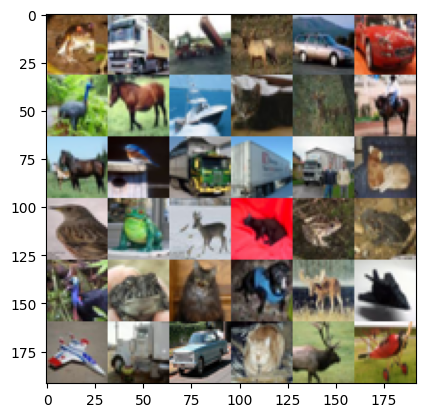

Build Generator
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2048)              206848    
                                                                 
 reshape_3 (Reshape)         (None, 2, 2, 512)         0         
                                                                 
 batch_normalization_24 (Bat  (None, 2, 2, 512)        2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 4, 4, 256)        3277056   
 Transpose)                                                      
                                                                 
 batch_normalization_25 (Bat  (None, 4

None


<ipython-input-14-ff4084f55f66>:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(1, epochs+1)):


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10
2/2 [==============================] - 0s 6ms/step


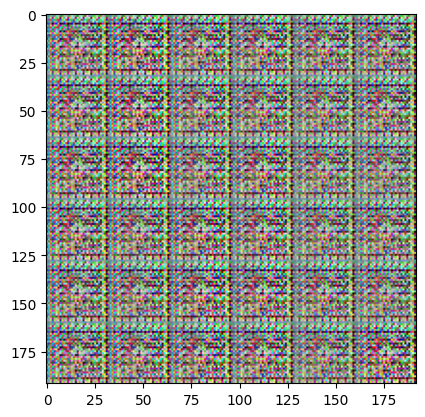

Epoch 20
2/2 [==============================] - 0s 6ms/step


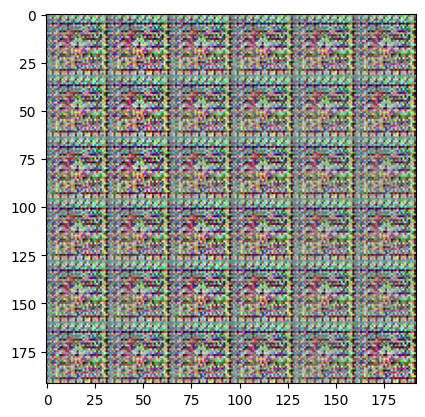

Epoch 30
2/2 [==============================] - 0s 5ms/step


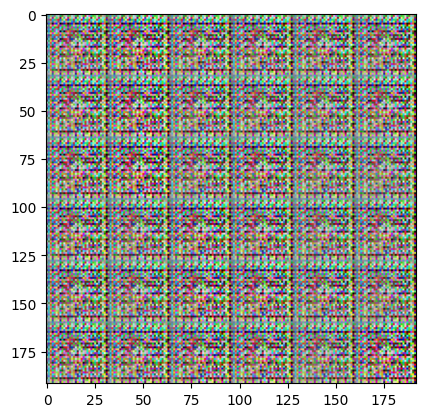

Epoch 40
2/2 [==============================] - 0s 5ms/step


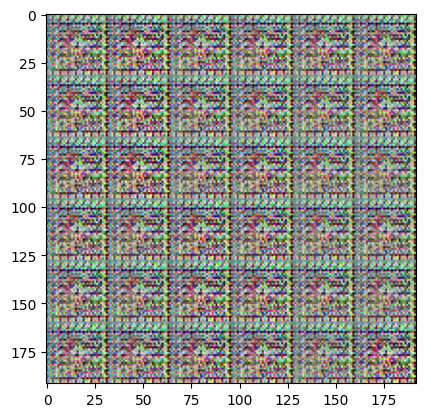

Epoch 50
2/2 [==============================] - 0s 7ms/step


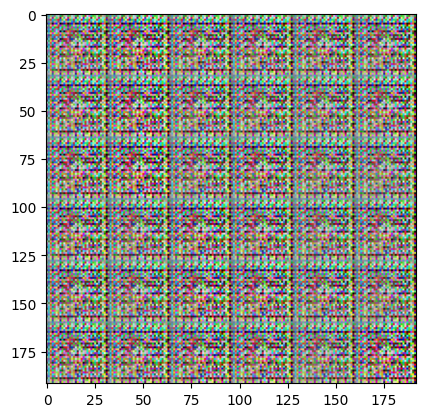

In [15]:
train()

### References

[Bài 2: Deep Convolutional Generative Adversarial Network (DCGAN)](https://nttuan8.com/bai-2-deep-convolutional-gan-dcgan/)

[Bài 3: Conditional GAN (cGAN)](https://nttuan8.com/bai-3-conditional-gan-cgan/)

[Bài 4: Least Squares Generative Adversarial Networks (LSGAN)](https://nttuan8.com/bai-4-least-squares-generative-adversarial-networks-lsgan/)

[Bài 5: GAN evaluation](https://nttuan8.com/bai-5-gan-evaluation/)